## Table of Contents

### 1. Importing your libraries and data
### 2. Subsetting, wrangling and cleaning time-series data
### 3. Time series analysis: decomposition
### 4. Testing for stationarity
### 5. Stationarizing

### 1. Importing your libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
#Import Data

bird = pd.read_csv(r'/Users/lynnsey/Desktop/Bootcamp/Tasks/Immersion/Task 6/09-07-2023 Living Planet Index Analysis/02 Data/Prepared Data/birds_yearly_avg_sum_after_1974.csv', index_col = False)

In [3]:
bird.head(5)

,year,average,sum
0,1/1/75,10250.72,21803271.97
1,1/1/76,7706.66,16407484.01
2,1/1/77,8535.89,18727743.22
3,1/1/78,20036.96,45363680.83
4,1/1/79,21538.32,51455053.05


In [4]:
bird.shape

(45, 3)

In [5]:
bird.columns

Index(['year', 'average', 'sum'], dtype='object')

In [57]:
bird['average'] = bird['average'].astype('float')

In [6]:
type(bird)

pandas.core.frame.DataFrame

In [7]:
data = bird.drop(columns = ['sum'])

In [8]:
data.head(5)

,year,average
0,1/1/75,10250.72
1,1/1/76,7706.66
2,1/1/77,8535.89
3,1/1/78,20036.96
4,1/1/79,21538.32


In [9]:
data.dtypes

year        object
average    float64
dtype: object

### 2. Subsetting, wrangling, and cleaning time-series data

##### I cleaned the data in excel since I had to transpose, etc. and it just seemed easier with my dataset.  I made a new dataset with just years and the average and the sum of birds counted per year. I only included counts after 1974 because there weren't many done before that year and I thought this would bias the data.

In [10]:
# Set the "year" column as the index

from datetime import datetime

data['datetime'] = pd.to_datetime(data['year']) # Create a datetime column from "year."
data = data.set_index('datetime') # Set the datetime as the index of the dataframe.
data.drop(['year'], axis=1, inplace=True) # Drop the "Date" column.
data.head()

,average
datetime,
1975-01-01,10250.72
1976-01-01,7706.66
1977-01-01,8535.89
1978-01-01,20036.96
1979-01-01,21538.32


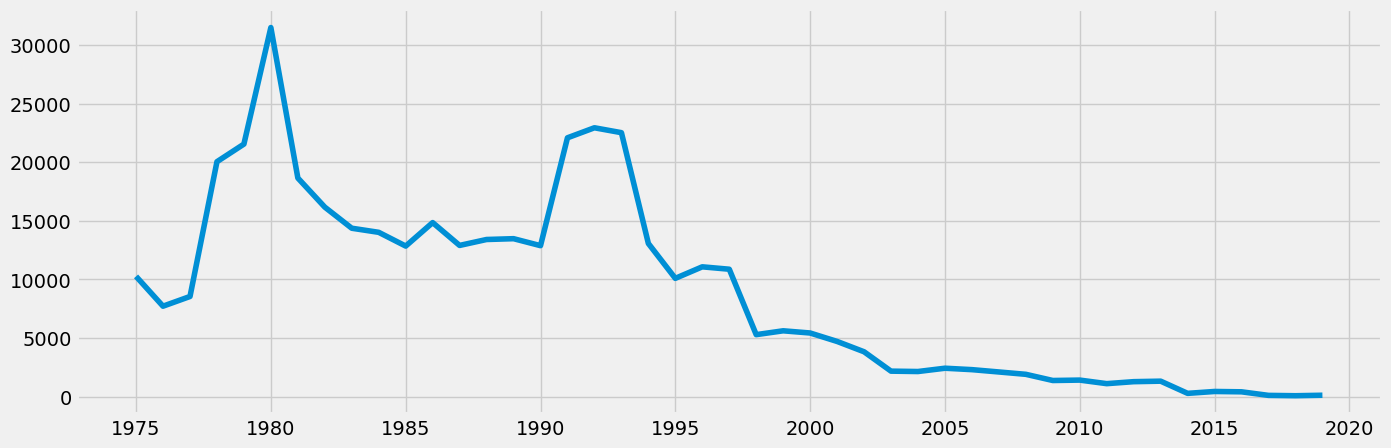

In [11]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data)

In [12]:
# Check for missing values (you shouldn't have any)

data.isnull().sum() 

average    0
dtype: int64

In [13]:
data_sub.head()

,Date,Value
124,1980-01-01,6.217371
125,1980-04-01,6.210709
126,1980-07-01,6.203388
127,1980-10-01,6.195496
128,1981-01-01,6.187123


In [13]:
# Check for duplicates

dups = data.duplicated()
dups.sum()

# No dups!

0

In [28]:
# Changing name for ease of copying code below

data_sub = data

### 3. Time-series analysis: decomposition

In [15]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [16]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

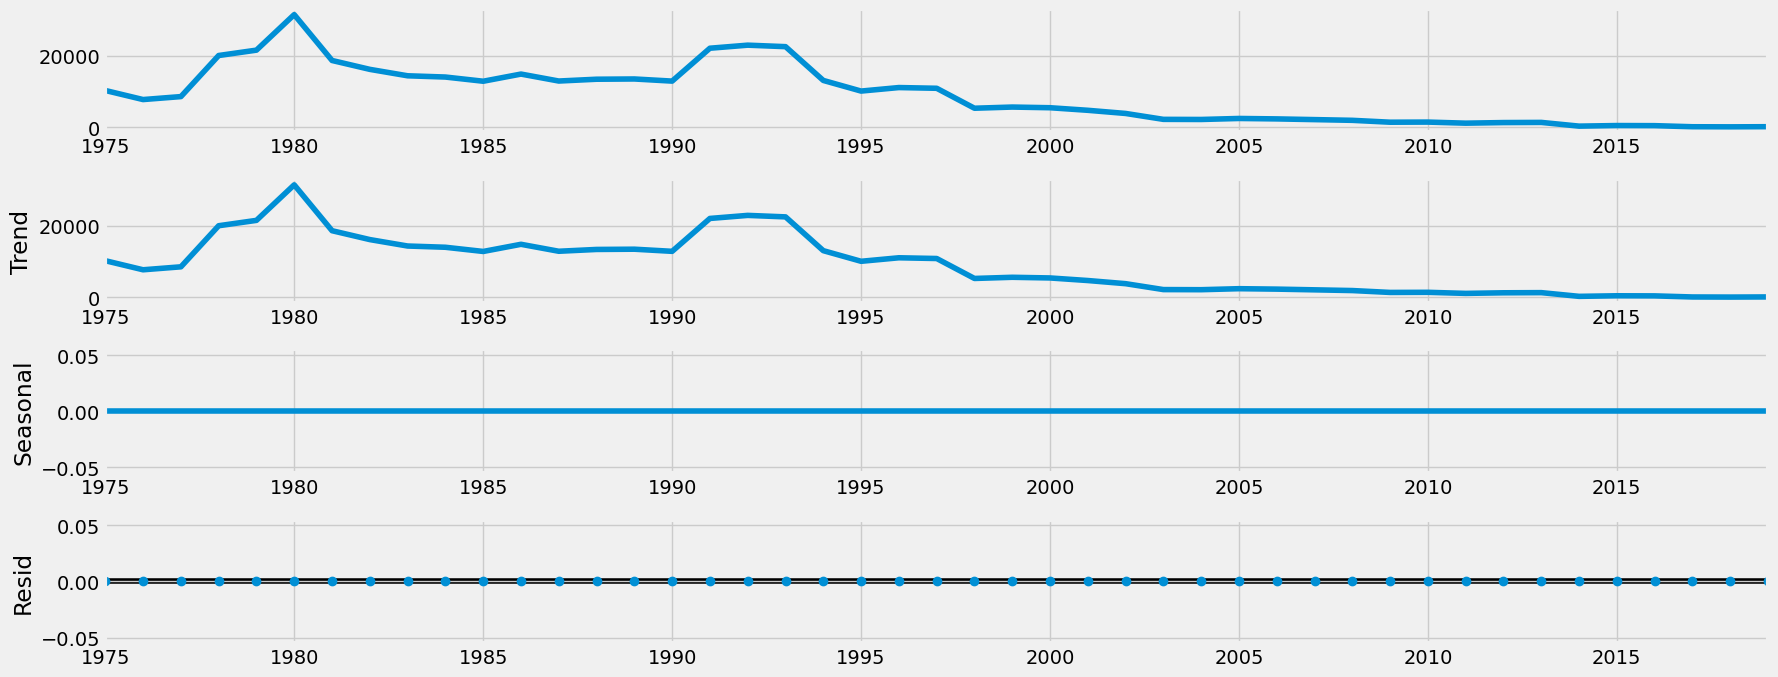

In [17]:
# Plot the separate components

decomposition.plot()
plt.show()

##### It looked like there is no seasonality or noise in my data.  I see a downward trend. I'm not sure what accounts for the jump in 1980 and between 1990-1995 in my data that I see in the trend and in the level.  It could have been that there was a species counted those years that has a very large population that wasn't counted other years.  

### 4. Testing for stationarity

In [19]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['average'])

Dickey-Fuller Stationarity test:
Test Statistic                 -1.420238
p-value                         0.572536
Number of Lags Used             0.000000
Number of Observations Used    44.000000
Critical Value (1%)            -3.588573
Critical Value (5%)            -2.929886
Critical Value (10%)           -2.603185
dtype: float64


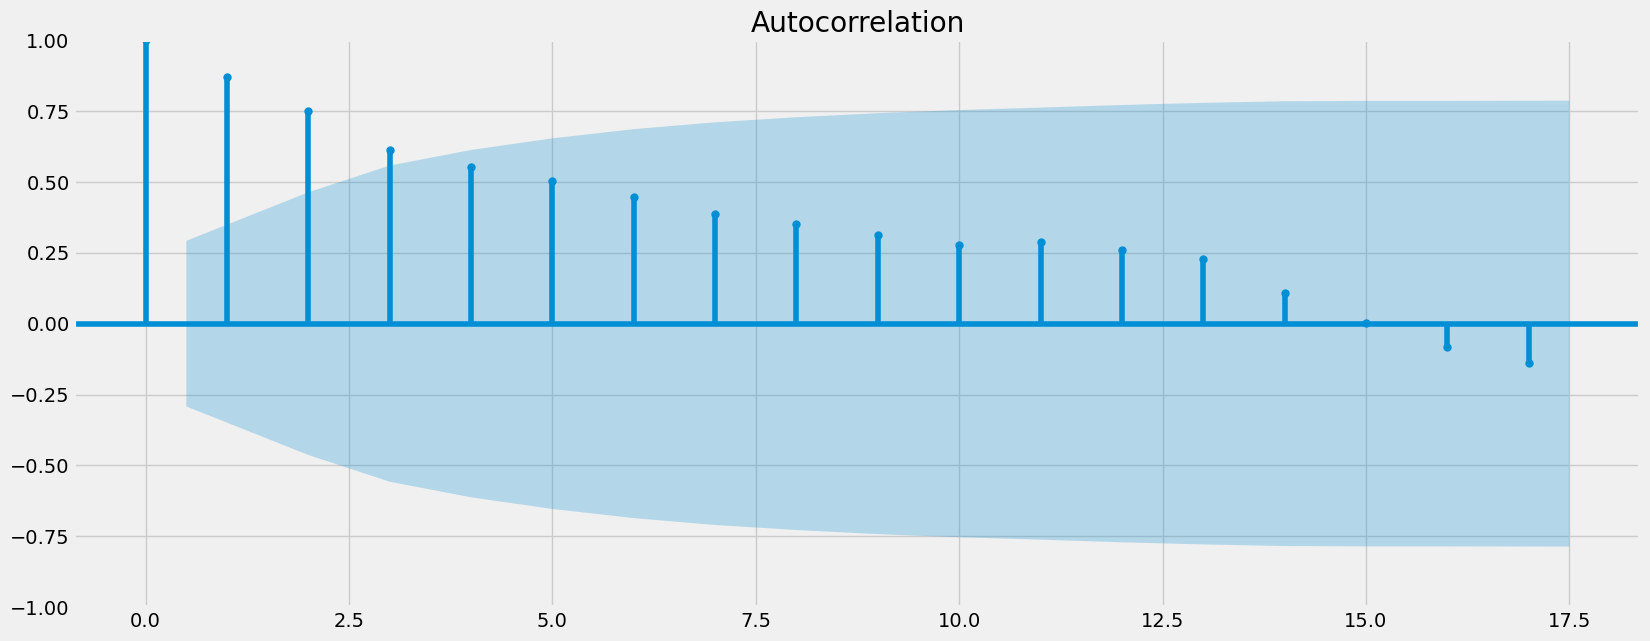

In [20]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

##### The null hypothesis is the presence of a unit root.  The alternative hypothesis is that there is no unit root.  My test statistic is -1.420238 and my critical value (5%) is -2.929886, which is smaller than the test statistic.  This means I can't reject my null hypothesis; there is a unit root in my data and my data is non-stationary.  Looking at the autocrrelation there are 4 lags outside of the confidence interval.

### 5. Stationarizing the Data

In [21]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [22]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [23]:
data_diff.head()

,average
datetime,
1976-01-01,-2544.06
1977-01-01,829.23
1978-01-01,11501.07
1979-01-01,1501.36
1980-01-01,9945.58


In [24]:
data_diff.columns

Index(['average'], dtype='object')

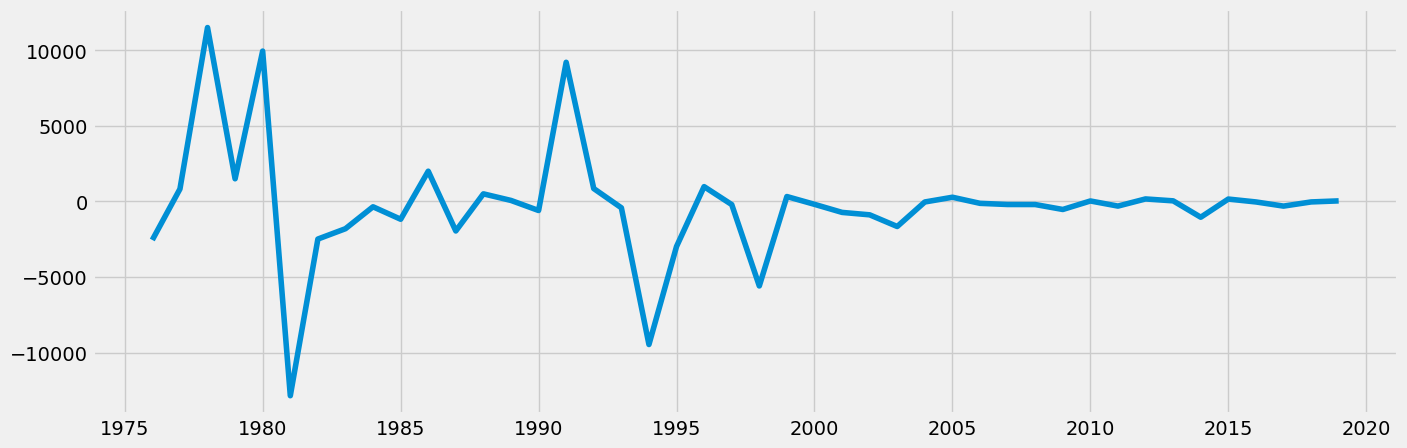

In [25]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [26]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -2.023493
p-value                         0.276368
Number of Lags Used            10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


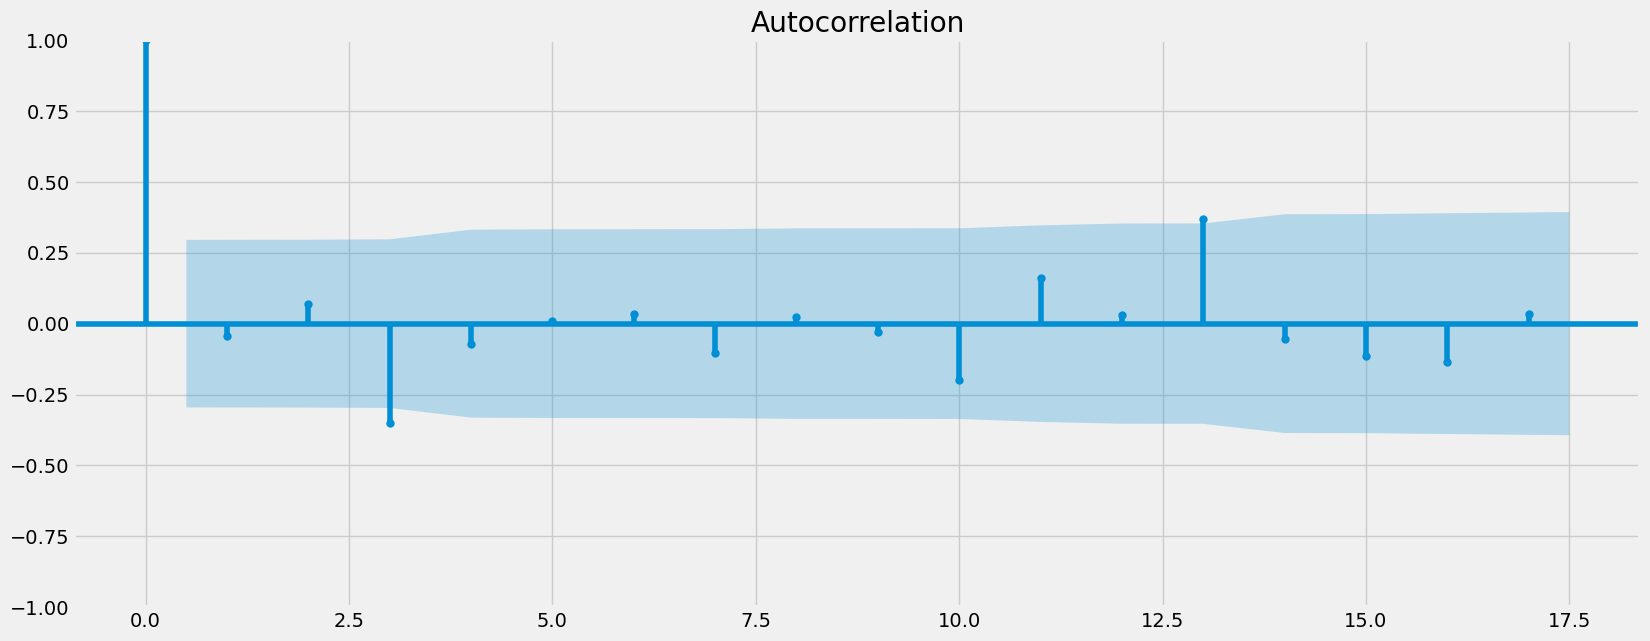

In [27]:
plot_acf(data_diff)
plt.show()

##### My data still isn't stationary.  My test statistic is still larger than the critical value (5%).  So I decided to do another round of differencing to make my data stationary.

In [29]:
data_diff_1 = data_diff - data_diff.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [30]:
data_diff_1.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [32]:
data_diff_1.head()

,average
datetime,
1977-01-01,3373.29
1978-01-01,10671.84
1979-01-01,-9999.71
1980-01-01,8444.22
1981-01-01,-22787.61


In [33]:
data_diff_1.columns

Index(['average'], dtype='object')

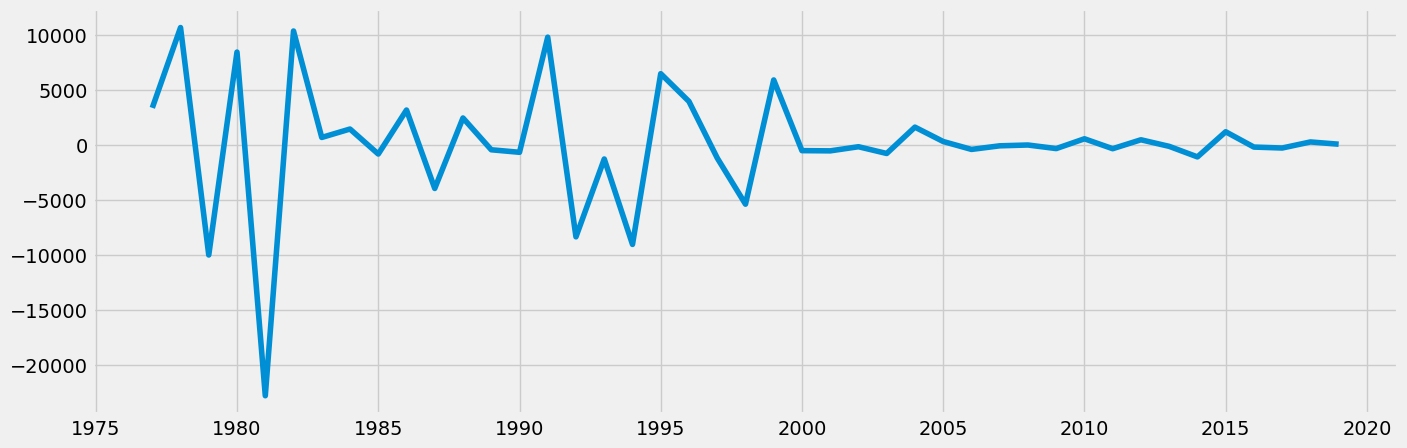

In [34]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_1)

In [35]:
dickey_fuller(data_diff_1)

Dickey-Fuller Stationarity test:
Test Statistic                 -3.784362
p-value                         0.003071
Number of Lags Used             9.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


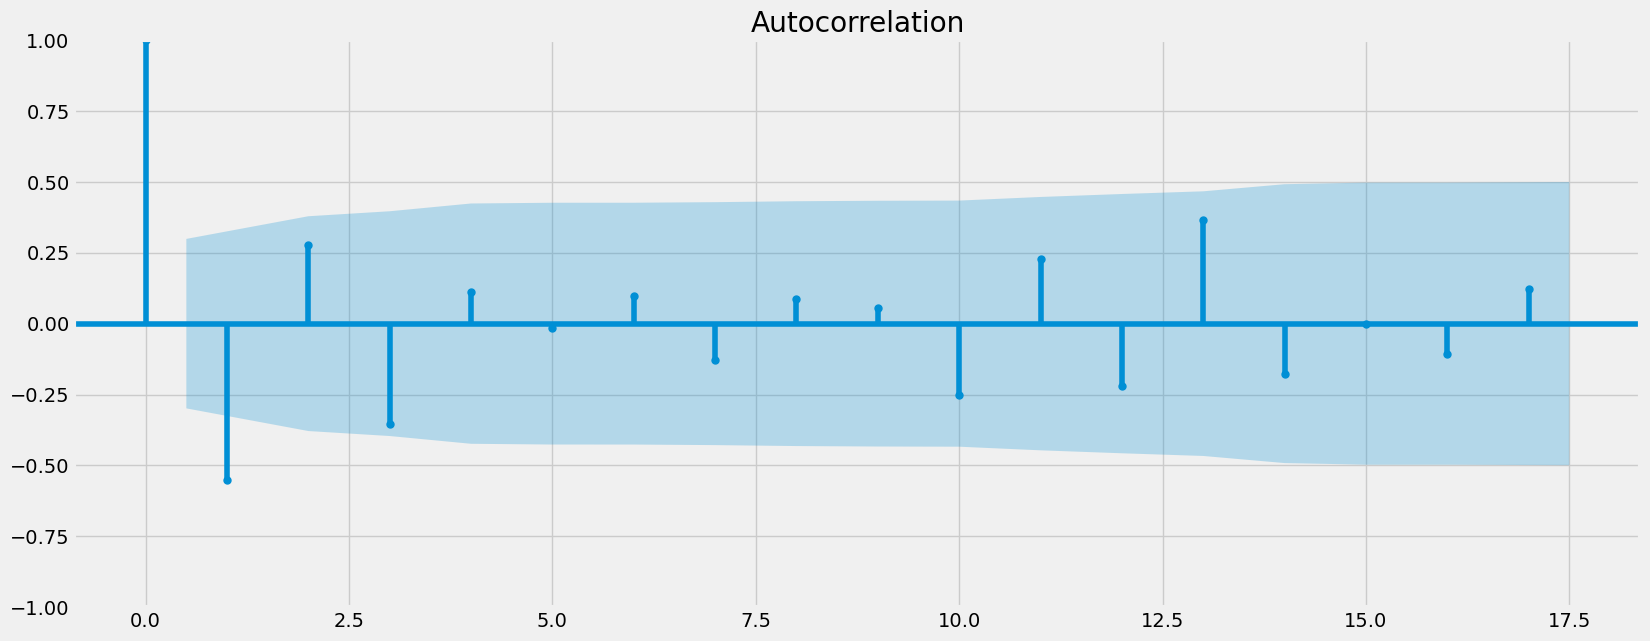

In [36]:
plot_acf(data_diff_1)
plt.show()

##### My test statistic is now smaller than the critival value (5%) and I have a signifcant p-value.  So I can rekect the null hypothesis and consider my data stationary.